In [1]:
import sys 
sys.path.append('../')

import itertools
import numpy as np
import matplotlib.pyplot as plt
from qiskit import Aer
from qiskit.compiler import transpile
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector
from qiskit.algorithms.optimizers import SPSA
from quantum_neural_networks import StateDiscriminativeQuantumNeuralNetworks as nnd, QuantumState 
import qutip
%precision 3

'%.3f'

In [2]:
def povm( n: int, theta_u: [float], phi_u: [float], lambda_u: [float], theta1: [float], theta2: [float],
            theta_v1: [float], theta_v2: [float], phi_v1: [float], phi_v2: [float], lambda_v1: [float],
            lambda_v2: [float], output = 'povm' ):
    
    circuit = nnd.get_n_element_povm( n, theta_u, phi_u, lambda_u, theta1, theta2,
            theta_v1, theta_v2, phi_v1, phi_v2, lambda_v1,
            lambda_v2)
    circuit.save_unitary()
    
    backend = Aer.get_backend('aer_simulator_unitary')
    circuit = transpile( circuit, backend ) 
    results = backend.run( circuit ).result()
    
    U = results.get_unitary()
    
    if output == 'unitary':
        return U
    else:
        U = U.reshape( 2**(n-1), 2, 2**(n-1), 2 )
        M = []
        for m in range(2**(n-1)):
            if output=='kraus':
                M.append( U[m,:,0,:] )  
            elif output =='povm':
                M.append( U[m,:,0,:].T.conj()@U[m,:,0,:] ) 

        return M

In [3]:
def get_bloch_vector( operator ):
    
    sx = np.array([ [0, 1], [1, 0] ])
    sy = np.array([ [0, -1j], [1j, 0] ])
    sz = np.array([ [1, 0], [0, -1] ])
    
    if isinstance( operator, np.ndarray ):
        operator = [operator]
        
    vecs = []
    for O in operator:
        
        if O.ndim == 1 :
            O = np.outer( O, O.T.conj() )

        vecs.append( [ np.real( np.trace( O@sx ) ), 
                       np.real( np.trace( O@sy ) ),
                       np.real( np.trace( O@sz ) )  ])

    return vecs[0] if len(vecs)==1 else vecs

In [4]:
def callback( params, results, prob_error, prob_inc, prob):
    datos.append(prob_error) 

In [5]:
backend = Aer.get_backend('aer_simulator_unitary')

[[-0.26563616443523647, -0.6476170619088567, -0.593040339327708], [-0.00652295712514471, 0.35363856491332984, 0.16489699685774684], [8.535640645183507e-34, -1.1524175156094098e-32, -4.1369961158541706e-33], [0.27215912156038136, 0.29397849699552725, 0.428143342469961]]
[[1.000e+00+0.000e+00j 8.327e-17-1.943e-16j]
 [8.327e-17+1.943e-16j 1.000e+00+0.000e+00j]]


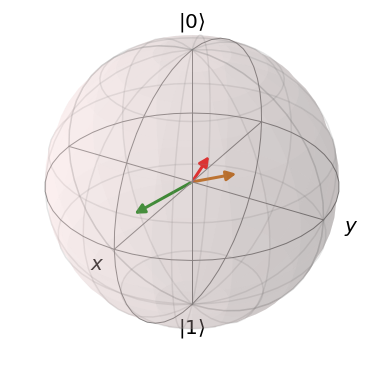

In [6]:
# Parameters
n = 3

np.random.seed(17)
th_u, fi_u, lam_u = [np.pi*np.random.randn()], [np.pi*np.random.randn()], [np.pi*np.random.randn()]
th1, th2       = np.pi*np.random.randn(n-1), np.pi*np.random.randn(n-1)
th_v1, th_v2   = np.pi*np.random.randn(n-1), np.pi*np.random.randn(n-1)
fi_v1, fi_v2   = np.pi*np.random.randn(n-1), np.pi*np.random.randn(n-1)
lam_v1, lam_v2 = np.pi*np.random.randn(n-1), np.pi*np.random.randn(n-1)

circuit = nnd.get_n_element_povm( n, 
                                    th_u, fi_u, lam_u, 
                                    th1, th2, 
                                    th_v1, th_v2, 
                                    fi_v1, fi_v2, 
                                    lam_v1, lam_v2 )
#circuit = transpile( circuit, backend )

M = povm(  n, 
            th_u, fi_u, lam_u, 
            th1, th2, 
            th_v1, th_v2, 
            fi_v1, fi_v2, 
            lam_v1, lam_v2 , output='povm')

vecs = get_bloch_vector( M )

print( vecs )
print( np.sum( M ,axis=0) )

b = qutip.Bloch()
b.add_vectors( vecs[0])
b.add_vectors( vecs[1])
b.add_vectors( vecs[2])
b.add_vectors( vecs[3])
b.render()

In [7]:
def callback( params, results, prob_error, prob_inc, prob):
    datos.append( params ) 

ψ = QuantumState( [ np.array([1, 1])/np.sqrt(2) ] )
ϕ = QuantumState( [ np.array([1, -1])/np.sqrt(2) ] )

th_u, fi_u, lam_u = [0], [0], [0]
th1, th2  = [0], [np.pi]
th_v1, th_v2 = [0], [0]
fi_v1, fi_v2 = [0], [0]
lam_v1, lam_v2 = [0],  [0]
params = list(itertools.chain(th_u, fi_u, lam_u, th1, th2, th_v1, th_v2, fi_v1, fi_v2, lam_v1, lam_v2))

discriminator = nnd( [ ψ, ϕ ] )
datos = [ ]
results = discriminator.discriminate( SPSA(100), params, callback=callback )

In [8]:
vec_ψ = get_bloch_vector( ψ.states[0] )
vec_ϕ = get_bloch_vector( ϕ.states[0] )

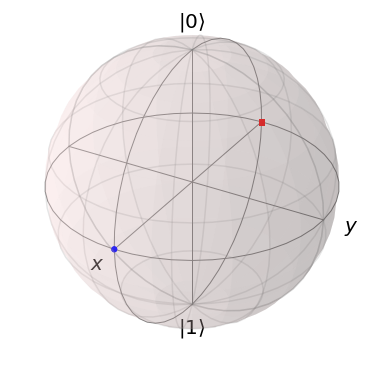

In [9]:
b = qutip.Bloch()
b.add_points(vec_ψ)
b.add_points(vec_ϕ)
b.render()
plt.savefig('bloch0.png')

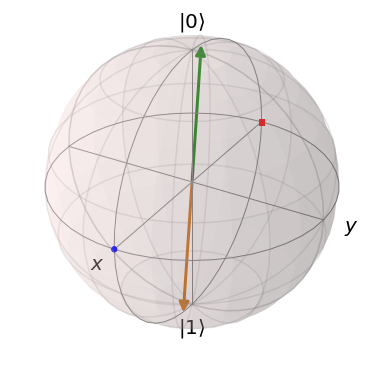

In [10]:
idex = 0
th_u, fi_u, lam_u, th1, th2, th_v1, th_v2, fi_v1, fi_v2, lam_v1, lam_v2 = datos[idex]
M = povm( 2, 
            [th_u], [fi_u], [lam_u], 
            [th1], [th2], 
            [th_v1], [th_v2], 
            [fi_v1], [fi_v2], 
            [lam_v1], [lam_v2] , output='povm')
vecs = get_bloch_vector( M )
b = qutip.Bloch()
b.add_points(vec_ψ)
b.add_points(vec_ϕ)
b.add_vectors( vecs[0])
b.add_vectors( vecs[1])
b.render()
plt.savefig('bloch1.png')

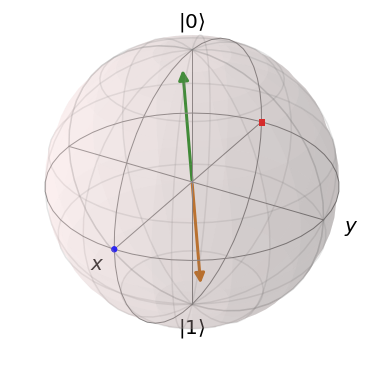

In [11]:
idex = 50
th_u, fi_u, lam_u, th1, th2, th_v1, th_v2, fi_v1, fi_v2, lam_v1, lam_v2 = datos[idex]
M = povm( 2, 
            [th_u], [fi_u], [lam_u], 
            [th1], [th2], 
            [th_v1], [th_v2], 
            [fi_v1], [fi_v2], 
            [lam_v1], [lam_v2] , output='povm')
vecs = get_bloch_vector( M )
b = qutip.Bloch()
b.add_points(vec_ψ)
b.add_points(vec_ϕ)
b.add_vectors( vecs[0])
b.add_vectors( vecs[1])
b.render()
plt.savefig('bloch2.png')

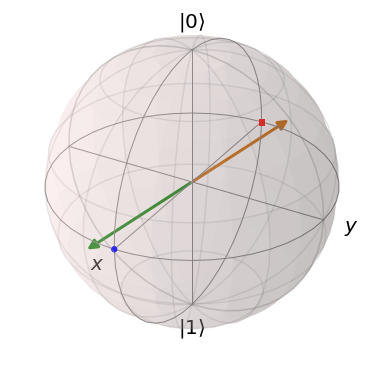

In [12]:
idex = 100
th_u, fi_u, lam_u, th1, th2, th_v1, th_v2, fi_v1, fi_v2, lam_v1, lam_v2 = datos[idex]
M = povm( 2, 
            [th_u], [fi_u], [lam_u], 
            [th1], [th2], 
            [th_v1], [th_v2], 
            [fi_v1], [fi_v2], 
            [lam_v1], [lam_v2] , output='povm')
vecs = get_bloch_vector( M )
b = qutip.Bloch()
b.add_points(vec_ψ)
b.add_points(vec_ϕ)
b.add_vectors( vecs[0])
b.add_vectors( vecs[1])
b.render()
plt.savefig('bloch3.png')

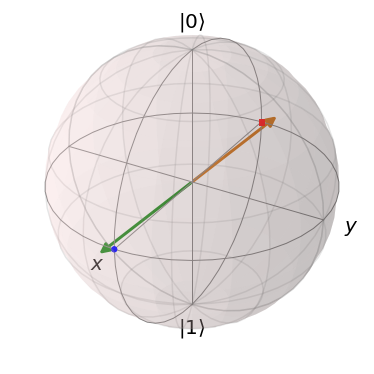

In [13]:
idex = 150
th_u, fi_u, lam_u, th1, th2, th_v1, th_v2, fi_v1, fi_v2, lam_v1, lam_v2 = datos[idex]
M = povm( 2, 
            [th_u], [fi_u], [lam_u], 
            [th1], [th2], 
            [th_v1], [th_v2], 
            [fi_v1], [fi_v2], 
            [lam_v1], [lam_v2] , output='povm')
vecs = get_bloch_vector( M )
b = qutip.Bloch()
b.add_points(vec_ψ)
b.add_points(vec_ϕ)
b.add_vectors( vecs[0])
b.add_vectors( vecs[1])
b.render()
plt.savefig('bloch4.png')

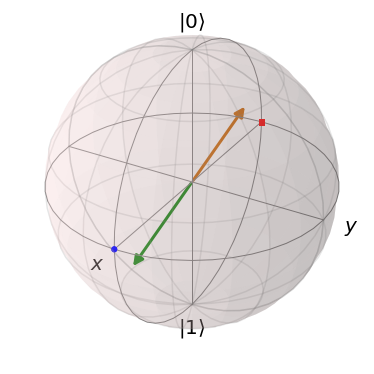

In [14]:
idex = 200
th_u, fi_u, lam_u, th1, th2, th_v1, th_v2, fi_v1, fi_v2, lam_v1, lam_v2 = datos[idex]
M = povm( 2, 
            [th_u], [fi_u], [lam_u], 
            [th1], [th2], 
            [th_v1], [th_v2], 
            [fi_v1], [fi_v2], 
            [lam_v1], [lam_v2] , output='povm')
vecs = get_bloch_vector( M )
b = qutip.Bloch()
b.add_points(vec_ψ)
b.add_points(vec_ϕ)
b.add_vectors(vecs[0])
b.add_vectors(vecs[1])
b.render()
plt.savefig('bloch5.png')

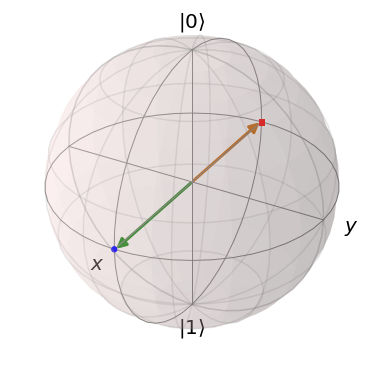

In [15]:
idex = -1
th_u, fi_u, lam_u, th1, th2, th_v1, th_v2, fi_v1, fi_v2, lam_v1, lam_v2 = datos[idex]
M = povm( 2, 
            [th_u], [fi_u], [lam_u], 
            [th1], [th2], 
            [th_v1], [th_v2], 
            [fi_v1], [fi_v2], 
            [lam_v1], [lam_v2] , output='povm')
vecs = get_bloch_vector( M )
b = qutip.Bloch()
b.add_points(vec_ψ)
b.add_points(vec_ϕ)
b.add_vectors( vecs[0])
b.add_vectors( vecs[1])
b.render()
plt.savefig('bloch6.png')